## Ground state approximation via VQE

In [3]:
import numpy as np

import qibo
from qibo import Circuit, gates, hamiltonians
from qibo import optimizers

from plotscripts import plot_state

qibo.set_backend("numpy")

[Qibo 0.2.5|INFO|2024-02-11 18:53:03]: Using numpy backend on /CPU:0


#### Problem setup: $H_{\rm target}$ and circuit $\mathcal{U}(\theta)$

In [4]:
def build_hamiltonian(nqubits, h):
    """
    Build Transverse Field Ising Model with `nqubits` and 
    transverse field `h`.
    """
    return hamiltonians.TFIM(nqubits=nqubits, h=h)

In [5]:
def build_vqe_circuit(nqubits, nlayers):
    """Build the Variational Quantum Eigensolver circuit."""
    c = Circuit(nqubits)
    for _ in range(nlayers):
        for q in range(nqubits):
            c.add(gates.RY(q=q, theta=0))
            c.add(gates.RZ(q=q, theta=0))
        for q in range(0, nqubits-1, 1):
            c.add(gates.CNOT(q0=q, q1=q+1))
        c.add(gates.CNOT(q0=nqubits-1, q1=0))
    c.add(gates.M(*range(nqubits)))
    return c

#### Loss function definition

In [6]:
def loss_function(parameters, circuit, hamiltonian):
    """
    Compute the expectation value of `hamiltonian` over the final state
    we get by executing `circuit` filled with `parameters`.
    """
    circuit.set_parameters(parameters)
    final_state = circuit().state()

    return hamiltonian.expectation(final_state)

#### Execution

In [13]:
nqubits = 4
nlayers = 6

c = build_vqe_circuit(nqubits, nlayers)
print(c.draw())

q0:     ─RY─RZ─o─────X─RY─RZ─o─────X─RY─RZ─o─────X─RY─RZ─o─────X─RY─RZ─o─────X ...
q1:     ─RY─RZ─X─o───|─RY─RZ─X─o───|─RY─RZ─X─o───|─RY─RZ─X─o───|─RY─RZ─X─o───| ...
q2:     ─RY─RZ───X─o─|─RY─RZ───X─o─|─RY─RZ───X─o─|─RY─RZ───X─o─|─RY─RZ───X─o─| ...
q3:     ─RY─RZ─────X─o─RY─RZ─────X─o─RY─RZ─────X─o─RY─RZ─────X─o─RY─RZ─────X─o ...

q0: ... ─RY─RZ─o─────X─M─
q1: ... ─RY─RZ─X─o───|─M─
q2: ... ─RY─RZ───X─o─|─M─
q3: ... ─RY─RZ─────X─o─M─


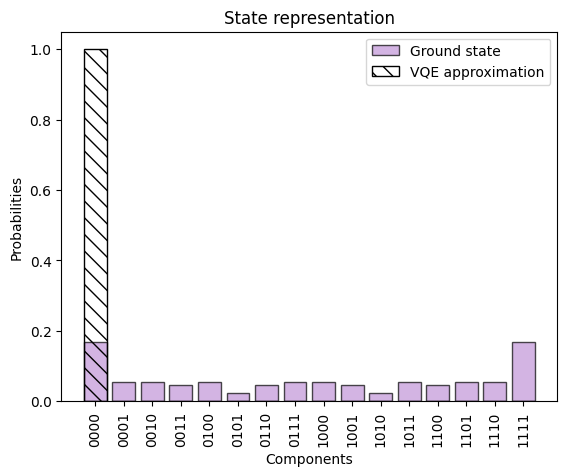

In [14]:
h = build_hamiltonian(nqubits, h=2)
ground_state = h.ground_state()
plot_state(ground_state, c().state())

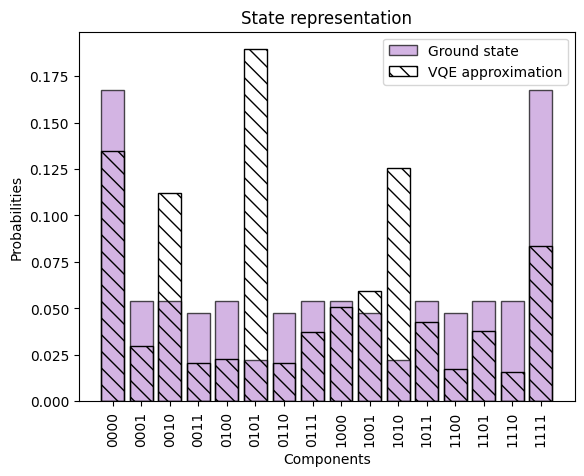

In [15]:
# set initial parameters
np.random.seed(42)
nparams = len(c.get_parameters())
initial_p = np.random.randn(nparams)

# final state after execution with random parameters
c.set_parameters(initial_p)

plot_state(ground_state, c().state())

In [16]:
result = optimizers.optimize(
    loss=loss_function, 
    initial_parameters=initial_p,
    args=(c, h),
    method="Powell"
)

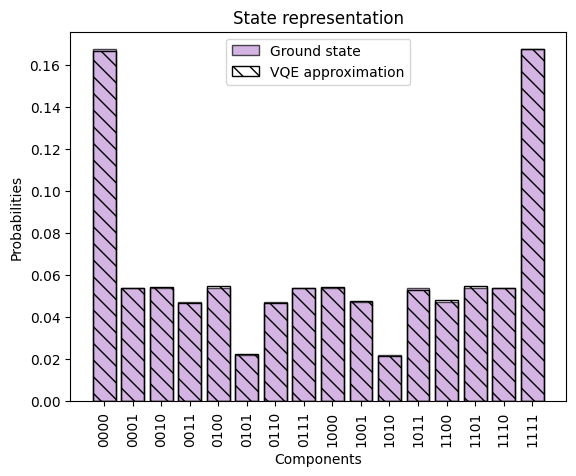

In [17]:
best_p = result[1]
c.set_parameters(best_p)

plot_state(ground_state, c().state())